<a href="https://colab.research.google.com/github/databyhuseyn/DeepLearning/blob/main/Training_Deep_Neural_Networks_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

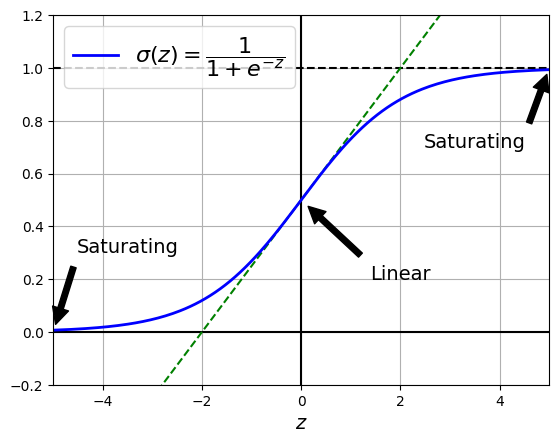

In [2]:
# extra code – this cell generates Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

# Glorot and He Initialization

In [3]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [4]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [5]:
import numpy as np

In [6]:
out = np.random.randn(1000) * 9

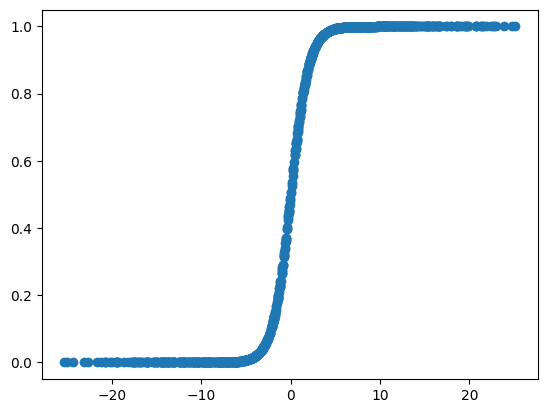

In [7]:
plt.scatter(out, sigmoid(out))

In [8]:
out = np.random.randn(1000) * (3 ** 0.5)

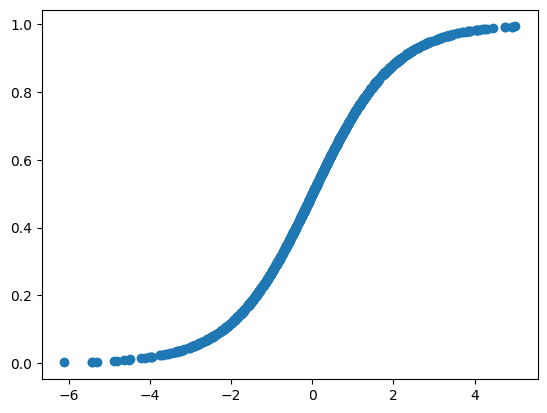

In [9]:
plt.scatter(out, sigmoid(out))

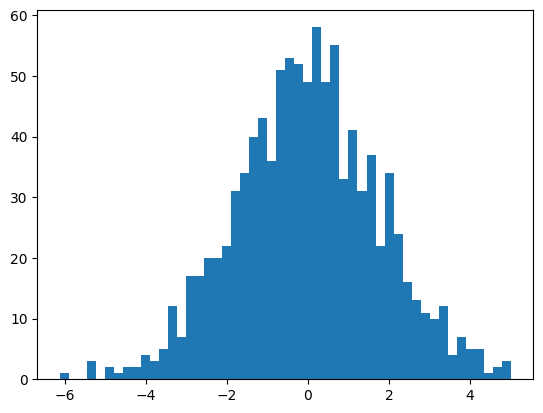

In [10]:
plt.hist(out, bins=50);

In [11]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50, 40), nn.ReLU(), nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [12]:
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

# Better Activation Functions

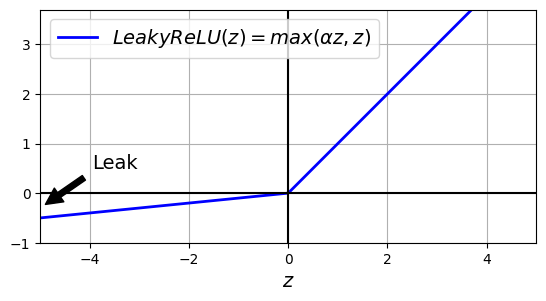

In [13]:
# extra code – this cell generates Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [14]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

In [15]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

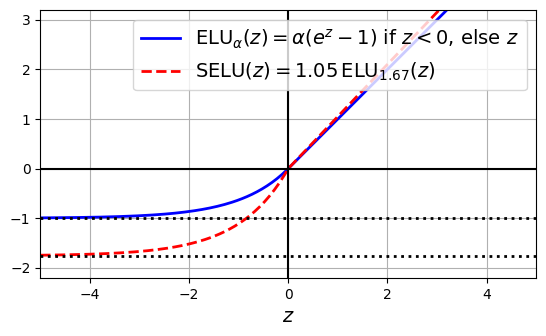

In [16]:
# extra code – this cell generates Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [17]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# GELU, Swish, SwiGLU, Mish, and ReLU²

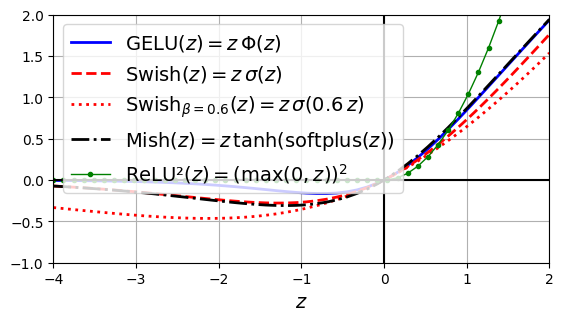

In [18]:
# extra code – this cell generates Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

def relu_squared(z):
    return np.maximum(0, z)**2

z = np.linspace(-4, 2, 50)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "k-.", linewidth=2,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot(z, relu_squared(z), "g.-", linewidth=1,
         label=fr"ReLU²$(z) = (\max(0, z))^2$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

### SwiGLU

In [19]:
class SwiGLU(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        z1, z2 = x.chunk(2, dim=-1)
        param_swish = z1 * torch.sigmoid(self.beta * z1)
        return param_swish * z2

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 2 * 40), SwiGLU(beta=0.2))
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### ReLU2

In [20]:
import torch.nn.functional as F

class ReLU2(nn.Module):
    def forward(self, x):
        return F.relu(x).square()

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), ReLU2())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# Batch Normalization

In [21]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [22]:
dict(model[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [23]:
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

In [24]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# Layer Normalization

In [25]:
torch.manual_seed(42)

inputs = torch.randn(32, 3, 100, 200)  # a batch of random RGB images
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)  # normalizes over the last two dimensions


In [26]:
means = inputs.mean(dim=[2, 3], keepdim=True)
vars_ = inputs.var(dim=[2, 3], keepdim=True, unbiased=False)
stds = torch.sqrt(vars_ + layer_norm.eps)
result2 = layer_norm.weight * (inputs - means) / stds + layer_norm.bias
assert torch.allclose(result, result2)


In [27]:
layer_norm = nn.LayerNorm([3, 100, 200])
result = layer_norm(inputs)  # normalizes over the last three dimensions

### Gradient Clipping

# Reusing Pretrained Layers
### Transfer Learning with PyTorch

In [28]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

In [29]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 58.6 MB/s eta 0:00:00


In [30]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [31]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

In [32]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 8)
)
model_A = model_A.to(device)

In [33]:
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

In [34]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.6363, train metric: 0.7845, valid metric: 0.8390
Epoch 2/20, train loss: 0.3525, train metric: 0.8790, valid metric: 0.8880
Epoch 3/20, train loss: 0.3054, train metric: 0.8943, valid metric: 0.8975
Epoch 4/20, train loss: 0.2811, train metric: 0.9007, valid metric: 0.8320
Epoch 5/20, train loss: 0.2652, train metric: 0.9073, valid metric: 0.8915
Epoch 6/20, train loss: 0.2519, train metric: 0.9125, valid metric: 0.8950
Epoch 7/20, train loss: 0.2397, train metric: 0.9162, valid metric: 0.8910
Epoch 8/20, train loss: 0.2317, train metric: 0.9194, valid metric: 0.9075
Epoch 9/20, train loss: 0.2234, train metric: 0.9224, valid metric: 0.9015
Epoch 10/20, train loss: 0.2149, train metric: 0.9248, valid metric: 0.9040
Epoch 11/20, train loss: 0.2098, train metric: 0.9276, valid metric: 0.9150
Epoch 12/20, train loss: 0.2029, train metric: 0.9286, valid metric: 0.8985
Epoch 13/20, train loss: 0.1982, train metric: 0.9305, valid metric: 0.9210
Epoch 14/20, train lo

In [35]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

In [36]:
model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

In [37]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 1.1117, train metric: 0.4000, valid metric: 0.5032
Epoch 2/20, train loss: 0.8887, train metric: 0.4000, valid metric: 0.5036
Epoch 3/20, train loss: 0.7477, train metric: 0.4000, valid metric: 0.5181
Epoch 4/20, train loss: 0.6618, train metric: 0.4000, valid metric: 0.5823
Epoch 5/20, train loss: 0.6067, train metric: 0.4500, valid metric: 0.6705
Epoch 6/20, train loss: 0.5684, train metric: 0.6000, valid metric: 0.7588
Epoch 7/20, train loss: 0.5382, train metric: 0.7000, valid metric: 0.8062
Epoch 8/20, train loss: 0.5149, train metric: 0.9000, valid metric: 0.8359
Epoch 9/20, train loss: 0.4962, train metric: 0.9500, valid metric: 0.8512
Epoch 10/20, train loss: 0.4804, train metric: 0.9500, valid metric: 0.8606
Epoch 11/20, train loss: 0.4671, train metric: 0.9500, valid metric: 0.8651
Epoch 12/20, train loss: 0.4553, train metric: 0.9500, valid metric: 0.8697
Epoch 13/20, train loss: 0.4448, train metric: 0.9500, valid metric: 0.8731
Epoch 14/20, train lo

In [38]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.8860, device='cuda:0')

In [39]:
import copy

torch.manual_seed(43)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100, 1)  # new output layer for task B
).to(device)

In [40]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

In [40]:
n_epochs = 10
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

In [41]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [42]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.8847, train metric: 0.4000, valid metric: 0.4697
Epoch 2/20, train loss: 0.7805, train metric: 0.3000, valid metric: 0.5251
Epoch 3/20, train loss: 0.7299, train metric: 0.3500, valid metric: 0.6032
Epoch 4/20, train loss: 0.6987, train metric: 0.5500, valid metric: 0.6510
Epoch 5/20, train loss: 0.6744, train metric: 0.6000, valid metric: 0.6715
Epoch 6/20, train loss: 0.6531, train metric: 0.7000, valid metric: 0.6954
Epoch 7/20, train loss: 0.6334, train metric: 0.7000, valid metric: 0.7223
Epoch 8/20, train loss: 0.6149, train metric: 0.7500, valid metric: 0.7488
Epoch 9/20, train loss: 0.5974, train metric: 0.7500, valid metric: 0.7721
Epoch 10/20, train loss: 0.5807, train metric: 0.7500, valid metric: 0.7984
Epoch 11/20, train loss: 0.5649, train metric: 0.7500, valid metric: 0.8231
Epoch 12/20, train loss: 0.5499, train metric: 0.7500, valid metric: 0.8398
Epoch 13/20, train loss: 0.5357, train metric: 0.8500, valid metric: 0.8548
Epoch 14/20, train lo

In [43]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.9119, device='cuda:0')

### Add MUON Optimizer here